In [5]:
import sys
sys.path.insert(0, '../src')
import timing_analysis as ta
import segment_submovements as ss
import seaborn as sns
from scipy import io
import utils
import importlib
import pandas as pd
import h5py
import utils
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(ta)
importlib.reload(ss)
importlib.reload(utils)

trial_type = 'all'
lfads_filename = "../data/model_output/rockstar_final-fixed-2OLS24_%s.h5"%trial_type
data_filename = "../data/intermediate/rockstar.p"
inputInfo_filename = "../data/model_output/rockstar_inputInfo.mat"

#limits of window to look for peaks after target appearance
win_start = 0
win_stop = 0.5
# minimum distance between peaks
min_distance = 5
min_height = 0.3

df = pd.read_pickle(data_filename)
input_info = io.loadmat(inputInfo_filename)
with h5py.File(lfads_filename, 'r') as h5file:
    co = h5file['controller_outputs'].value
    dt = utils.get_dt(h5file, input_info)
    trial_len = utils.get_trial_len(h5file, input_info)
    n_inputs = h5file['controller_outputs'].shape[2]

/home/macleanlab/anaconda3/envs/lfads_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


NameError: name 'feedback_peaks' is not defined

In [8]:
def trial_feedback_peaks(trial_peaks, trial_df, merge_distance=0.05):
    n_peaks = sum(len(controller_peaks) for controller_peaks in trial_peaks)
    n_controllers = len(trial_peaks)
    ctrl_idx = np.concatenate([np.ones(len(cp),dtype=int)*i for i,cp in enumerate(trial_peaks)])
    peaks = np.concatenate(trial_peaks)
    ctrl_idx = ctrl_idx[np.argsort(peaks)]
    peaks = np.sort(peaks)
    unique_peaks = []
    i = 0
    target_df = trial_df.kinematic.query('hit_target')
    while i < peaks.shape[0]:
        ctrl_latencies = np.empty(n_controllers)
        ctrl_latencies[:] = np.nan
        ctrl_latencies[ctrl_idx[i]] = 0.0
        peak_time = peaks[i]       
        i += 1
        while i < peaks.shape[0] and (peaks[i] - peak_time) < merge_distance:
            ctrl_latencies[ctrl_idx[i]] = peaks[i] - peak_time
            i += 1
            
        unique_peaks.append(np.insert(ctrl_latencies, 0, peak_time))
    
    if len(unique_peaks) == 0:
        columns = ['time', 'x', 'y', 'x_vel', 'y_vel', 'target_x', 'target_y']
        for i in range(n_controllers):
            columns.append('latency_%d'%i)
        out_df = pd.DataFrame({c:[] for c in columns})
        out_df.set_index('time', inplace=True)
    else:
        unique_peaks = np.array(unique_peaks)
        try:
            t = trial_df.index[[trial_df.index.get_loc(p, 'nearest') for p in unique_peaks[:,0]]]
        except:
            import pdb;pdb.set_trace()
            
        t_next_target = target_df.index[[target_df.index.get_loc(p, 'backfill') for p in unique_peaks[:,0]]]

        out_df = trial_df.kinematic.loc[t][['x','y','x_vel', 'y_vel']]
        out_df['target_x'] = target_df.loc[t_next_target]['x'].values
        out_df['target_y'] = target_df.loc[t_next_target]['y'].values
        for i in range(n_controllers):
            out_df['latency_%d'%i] = unique_peaks[:,i+1]

    return out_df

def feedback_peaks(peaks, df, merge_distance=0.05):
    assert peaks.shape[0] == df.index[-1][0]+1
    trial_dfs = []
    for i in range(peaks.shape[0]):
        trial_dfs.append(trial_feedback_peaks(peaks[i], df.loc[i], merge_distance=merge_distance))
        if i%10 == 0:
            print('Trial %d of %d completed'%(i,peaks.shape[0]))
        
    return pd.concat(trial_dfs, axis=0, keys=range(peaks.shape[0]))

def single_histogram(pkdf, density=True, hand_reference=True, ax=None):
    if hand_reference:
        x = pkdf.target_x-pkdf.x
        y = pkdf.target_y-pkdf.y
    else:
        x = pkdf.x
        y = pkdf.y

    theta=np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
    utils.polar_hist(theta, 12, density, ax)
    
def plot_histograms(pkdf, density=True, hand_reference=True):
    plt.figure(figsize=(12,24))
    for i, hand_reference in enumerate([True, False]):
        ax = plt.subplot(5,2,1 + i, polar=True)
        if hand_reference:
            ax.set_title('Hand')
            x = pkdf.target_x-pkdf.x
            y = pkdf.target_y-pkdf.y
        else:
            ax.set_title('Shoulder')
            x = pkdf.x
            y = pkdf.y
        
        theta=np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
        utils.polar_hist(theta, 12, density, ax)
        plt.ylabel('Input 1', rotation=0)
        ax.yaxis.set_label_coords(-0.1,1.02)

        #plt.figure()
        theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.isnull()].values
        ax = plt.subplot(5,2,3 + i, polar=True)
        utils.polar_hist(theta, 12, density, ax)
        plt.ylabel('Input 2', rotation=0)
        ax.yaxis.set_label_coords(-0.1,1.02)

        #plt.figure()
        theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.notnull()].values
        ax = plt.subplot(5,2,5 + i, polar=True)
        utils.polar_hist(theta, 12, density, ax)
        plt.ylabel('Both', rotation=0)
        ax.yaxis.set_label_coords(-0.1,1.02)

        #plt.figure()
        theta=np.arctan2(y, x)[pkdf.latency_0.isnull() & pkdf.latency_1.isnull()].values
        ax = plt.subplot(5,2,7 + i, polar=True)
        utils.polar_hist(theta, 12, density, ax)
        plt.ylabel('Neither', rotation=0)
        ax.yaxis.set_label_coords(-0.1,1.02)
        
        #plt.figure()
        theta=np.arctan2(y, x)
        ax = plt.subplot(5,2,9 + i, polar=True)
        utils.polar_hist(theta, 12, density, ax)
        plt.ylabel('All Targets', rotation=0)
        ax.yaxis.set_label_coords(-0.1,1.02)

In [9]:
peaks=ta.get_peaks(co, dt, min_height, exclude_post_target=0.25, df=df)
peak_df=feedback_peaks(peaks, df)

Trial 0 of 713 completed
Trial 10 of 713 completed
Trial 20 of 713 completed
Trial 30 of 713 completed
Trial 40 of 713 completed
Trial 50 of 713 completed
Trial 60 of 713 completed
Trial 70 of 713 completed
Trial 80 of 713 completed
Trial 90 of 713 completed
Trial 100 of 713 completed
Trial 110 of 713 completed
Trial 120 of 713 completed
Trial 130 of 713 completed
Trial 140 of 713 completed
Trial 150 of 713 completed
Trial 160 of 713 completed
Trial 170 of 713 completed
Trial 180 of 713 completed
Trial 190 of 713 completed
Trial 200 of 713 completed
Trial 210 of 713 completed
Trial 220 of 713 completed
Trial 230 of 713 completed
Trial 240 of 713 completed
Trial 250 of 713 completed
Trial 260 of 713 completed
Trial 270 of 713 completed
Trial 280 of 713 completed
Trial 290 of 713 completed
Trial 300 of 713 completed
Trial 310 of 713 completed
Trial 320 of 713 completed
Trial 330 of 713 completed
Trial 340 of 713 completed
Trial 350 of 713 completed
Trial 360 of 713 completed
Trial 370 of

/home/macleanlab/anaconda3/envs/lfads_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/macleanlab/anaconda3/envs/lfads_analysis/lib/python3.6/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


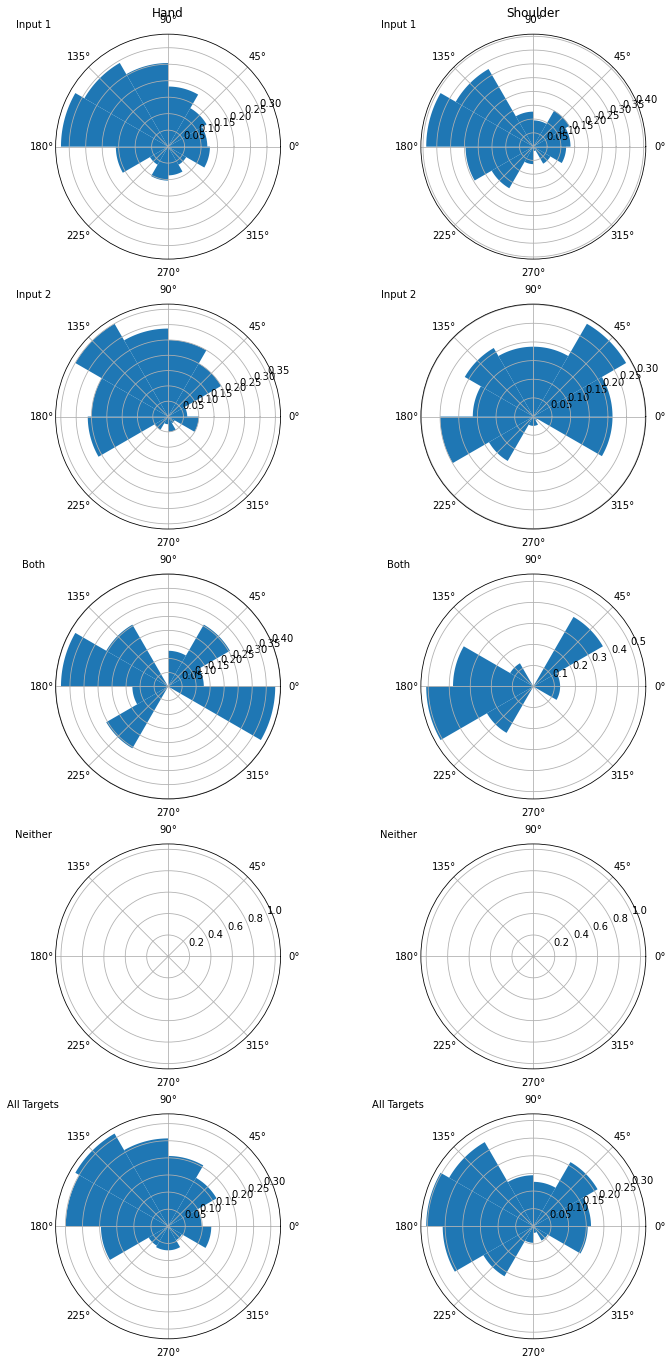

In [10]:
plot_histograms(peak_df)

In [14]:
target_peak_df = ta.get_peak_df(df, co, trial_len, min_height)

../src/timing_analysis.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_peaks.loc[trial_idx]['latency_%d'%input_idx].iloc[target_idx] = diff_targets[target_idx]


Text(0.5, 0.98, 'Rockstar')

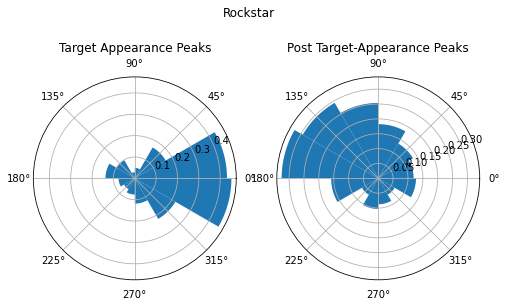

In [15]:
fig=plt.figure(figsize=(8,5))
ax=plt.subplot(1,2,1,polar=True)
single_histogram(target_peak_df, ax=ax)
plt.title('Target Appearance Peaks', pad=15)

ax=plt.subplot(1,2,2, polar=True)
single_histogram(peak_df, ax=ax)
plt.title('Post Target-Appearance Peaks', pad=15)
fig.suptitle('Rockstar')

In [12]:
plt.subplots(3,1,1)

NameError: name 'peak_df' is not defined